<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/DUDL_metalparameters_learningRateDecay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

## Data

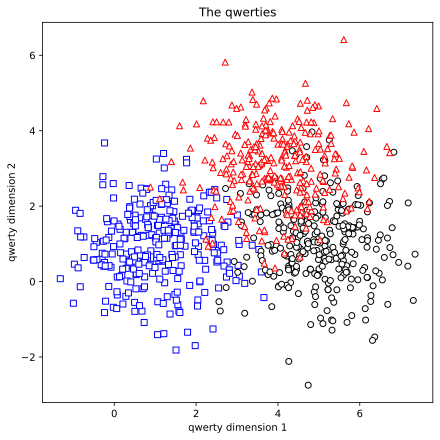

In [2]:
# create data
# create data 
nPerClust = 300
blur = 1

A = [1, 1]
B = [5, 1]
C = [4, 3]

# generate data
a = [A[0] + np.random.randn(nPerClust)*blur, A[1]+np.random.randn(nPerClust)*blur]
b = [B[0] + np.random.randn(nPerClust)*blur, B[1]+np.random.randn(nPerClust)*blur]
c = [C[0] + np.random.randn(nPerClust)*blur, C[1]+np.random.randn(nPerClust)*blur]

# true labels
labels_np = np.vstack((np.zeros((nPerClust, 1)), np.ones((nPerClust, 1)), np.ones((nPerClust, 1))+1))
# concatenate into a matrix
data_np = np.hstack((a, b, c)).T
# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.squeeze(torch.tensor(labels_np).long())

# show the data
fig = plt.figure(figsize=(7,7))
plt.plot(data[np.where(labels==0)[0], 0], data[np.where(labels==0)[0], 1], 'bs', markerfacecolor='w')
plt.plot(data[np.where(labels==1)[0], 0], data[np.where(labels==1)[0], 1], 'ko', markerfacecolor='w')
plt.plot(data[np.where(labels==2)[0], 0], data[np.where(labels==2)[0], 1], 'r^', markerfacecolor='w')
plt.title('The qwerties')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [3]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

# then convert into pytorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# finally, translate into dataloader objects
batchsize = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

## Model

In [4]:
# create a class for the model
def createTheQwertyNet(initialLR):

    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            ### input layer
            self.input = nn.Linear(2, 8)

            ## hidden layer
            self.fc1 = nn.Linear(8, 8)

            ## output layer
            self.output = nn.Linear(8, 3)

        # forward pass
        def forward(self, x):

            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))

            return self.output(x)

    # create the model instance
    net = qwertyNet()

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=initialLR)
    stepsize = batchsize*len(train_loader)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=stepsize, gamma=.5)
    
    return net, lossfun, optimizer, scheduler

In [5]:
len(train_loader) * batchsize

720

## Explore the learning rate decay parameter

In [6]:
# create a network
net = createTheQwertyNet(.01)[0]

# a new optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/2)

# test the change in learning rate
for epoch in range(3):
    for batchnum in range(10):
        print(f'Batch {batchnum}, epoch {epoch}: LR={scheduler.get_last_lr()[0]}')
        scheduler.step()

Batch 0, epoch 0: LR=0.01
Batch 1, epoch 0: LR=0.01
Batch 2, epoch 0: LR=0.01
Batch 3, epoch 0: LR=0.01
Batch 4, epoch 0: LR=0.01
Batch 5, epoch 0: LR=0.005
Batch 6, epoch 0: LR=0.005
Batch 7, epoch 0: LR=0.005
Batch 8, epoch 0: LR=0.005
Batch 9, epoch 0: LR=0.005
Batch 0, epoch 1: LR=0.0025
Batch 1, epoch 1: LR=0.0025
Batch 2, epoch 1: LR=0.0025
Batch 3, epoch 1: LR=0.0025
Batch 4, epoch 1: LR=0.0025
Batch 5, epoch 1: LR=0.00125
Batch 6, epoch 1: LR=0.00125
Batch 7, epoch 1: LR=0.00125
Batch 8, epoch 1: LR=0.00125
Batch 9, epoch 1: LR=0.00125
Batch 0, epoch 2: LR=0.000625
Batch 1, epoch 2: LR=0.000625
Batch 2, epoch 2: LR=0.000625
Batch 3, epoch 2: LR=0.000625
Batch 4, epoch 2: LR=0.000625
Batch 5, epoch 2: LR=0.0003125
Batch 6, epoch 2: LR=0.0003125
Batch 7, epoch 2: LR=0.0003125
Batch 8, epoch 2: LR=0.0003125
Batch 9, epoch 2: LR=0.0003125


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


## Training

In [13]:
numepochs = 50

def function2trainTheModel(initialLR, toggleDynamicLR):

    # create a new model
    net, lossfun, optimizer, scheduler = createTheQwertyNet(initialLR)

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []
    currentLR = []

    # loop over epochs
    for epochi in range(numepochs):
        
        #switch to training mode
        net.train()


        batchLoss = []
        batchAcc = []
        # loop over batches
        for X, y in train_loader:

            #forward pass
            yHat = net(X)
            loss = lossfun(yHat, y)

            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # step in learning-rate scheduler
            if toggleDynamicLR:
                scheduler.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat, axis=1) == y
            matchesNumeric = matches.float()
            accuracyPct = 100 * torch.mean(matchesNumeric)
            batchAcc.append(accuracyPct)

            currentLR.append(scheduler.get_last_lr()[0])


        # end of batch loop

        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        # compare the following really long line of code to the training accuracy lines
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()))
    # end epochs

    # function outputs
    return trainAcc, testAcc, losses, net, currentLR

            


## Test that the model really changes (sanity checks)

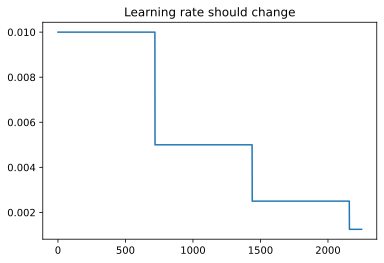

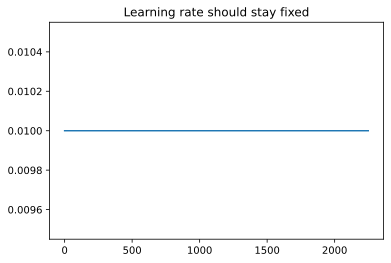

In [14]:
# test that the learning rate is really working
trainAcc, testAcc, losses, net, currentLR = function2trainTheModel(.01, True)
plt.plot(currentLR)
plt.title('Learning rate should change')
plt.show()

# test that the learning rate is really working
trainAcc, testAcc, losses, net, currentLR = function2trainTheModel(.01, False)
plt.plot(currentLR)
plt.title('Learning rate should stay fixed')
plt.show()



## Now for the experiment!

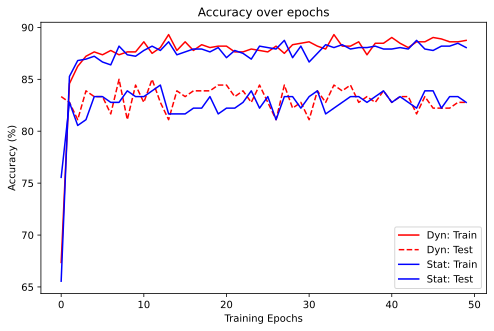

In [15]:
# run the model for one optimizer
trainAccDynamic, testAccDynamic, losses, net, currentLR = function2trainTheModel(.01, True)
trainAccStatic, testAccStatic, losses, net, currentLR = function2trainTheModel(.01, True)

fig = plt.figure(figsize=(8, 5))
plt.plot(trainAccDynamic,'r', label='Dyn: Train')
plt.plot(testAccDynamic, 'r--', label='Dyn: Test')

plt.plot(trainAccStatic, 'b', label='Stat: Train')
plt.plot(testAccStatic, 'b-', label='Stat: Test')

plt.legend()
plt.xlabel('Training Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over epochs')
plt.show()

In [ ]:
# create a 1D smoothing filter
def smooth(x, k=5):
    return np.convolve(x, np.ones(k) / k, mode='same')

In [ ]:
# run an experiment 
l2lambdas = np.linspace(0, .1, 6)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs, len(l2lambdas)))
accuracyResultsTest = np.zeros((numepochs, len(l2lambdas)))

# loop over batch sizes

for li in range(len(l2lambdas)):

    # create and train the model
    trainAcc, testAcc, losses, net = function2trainTheModel(l2lambdas[li])

    # store accuracies from last 100 epochs
    accuracyResultsTrain[:, li] = smooth(trainAcc)
    accuracyResultsTest[:, li] = smooth(testAcc)

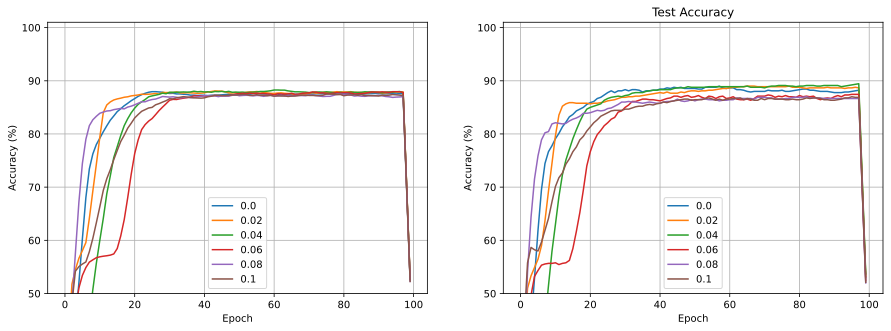

In [ ]:
# plot the experiment results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(accuracyResultsTrain)
ax[0].set_xlabel('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test Accuracy')

# make the legend easier to read
leglabels = [np.round(i, 2) for i in l2lambdas]

# common features
for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50, 101])
    ax[i].grid()


plt.show()